# SegFormer

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/lapix-ufsc/dl-tutorials/blob/main/tutorials/Semantic%20segmentation/Hugging%20Face/SegFormer.ipynb)

This tutorial is about [SegFormer](https://arxiv.org/abs/2105.15203) model using [HuggingFaces](https://huggingface.co/).

- Original implementation: [NVlabs/SegFormer](https://github.com/NVlabs/SegFormer)
- HF implementation: [docs](https://huggingface.co/docs/transformers/model_doc/segformer)



### Libraries 

* [albumentations](https://github.com/albumentations-team/albumentations) - For augmentation pipeline.
* [transformers](https://github.com/huggingface/transformers/) - For model structure.
* [Pytorch](https://github.com/pytorch/pytorch) - As model backend, and for the training loop, using: optimizer, learning rate scheduler, loss functions and other things.
* [datasets](https://github.com/huggingface/datasets) - To load the dataset.
* [matplotlib](https://github.com/matplotlib/matplotlib) - for visualization.
* [torchmetrics](https://github.com/Lightning-AI/metrics) - to evaluate the model when training the model
* [lapixdl](https://github.com/lapix-ufsc/lapixdl) - tool for model evaluation



### Summary

* Run setup - General settings of this tutorials: Here you will define the categories, dataset (from [HF datasets](https://huggingface.co/docs/datasets/index)), the pretrained model desired (from [HF models](https://huggingface.co/models)), and the path for the output files.
  * **Attention:** The dataset need to be a dataset for Semantic Segmentation, read the [CCAgT dataset card](https://huggingface.co/datasets/lapix/CCAgT) to understand the format. Also, the pretrained weights for the model for this tutorial should be from a **SegFormer** model.

* Setup requirements - Install and import the nescessary modules
  * **Attention:** If using google colab, you will probably need to restart the kernel because of the reinstallation of PIL.

* Load dataset - Load the dataset from the HF hub.

* Augmentations - Define the augmentation pipeline process.

* Rewrite the model - Just to only to assign weights to each class in the loss function

* HF definitions - A dataset class for the model, load the model and feature extractor, define the train metrics, and training functions.

* Train - The blocks to execute the train, splited into 2 steps

* Lapixdl evaluation - Load the best model and evaluate.



### Train "strategy" for the CCAgT dataset

- At this tutorial we apply `RandomCrop` from Albumentation to ensure images with size of 512x512 to train SegFormer.
- Use weights for each category for the loss function ([CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)).
- Use IoU metric to evaluate the model at pixel level when training the model.
- [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) as optimizer.
- [OneCycleLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html) as scheduler for the learning rate.
- Train into two steps:
  1. Train the model for `x` epochs with the encoder freezed.
  2. Load the model from the first step, and train for `x` epochs with the encoder unfreezed.


# Run setup

In [ ]:
# Values of each category at the segmentation mask
categories_to_train = {
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
}


# The main categories of the dataset, just to compute the metrics for specific categories
selected_categories = {
    1,
    2,
    3,
}

In [ ]:
loss_function_weights = [...]  # (need to edit) Weights for each category

The pretrained model can be:


|                       hub name                        | variant |    Depths     |    Hidden sizes     | Decoder hidden size | Params (M) | ImageNet-1k Top 1 |
| :---------------------------------------------------: | :-----: | :-----------: | :-----------------: | :-----------------: | :--------: | :---------------: |
| [nvidia/mit-b0](https://huggingface.co/nvidia/mit-b0) | MiT-b0  | [2, 2, 2, 2]  | [32, 64, 160, 256]  |         256         |    3.7     |       70.5        |
| [nvidia/mit-b1](https://huggingface.co/nvidia/mit-b1) | MiT-b1  | [2, 2, 2, 2]  | [64, 128, 320, 512] |         256         |    14.0    |       78.7        |
| [nvidia/mit-b2](https://huggingface.co/nvidia/mit-b2) | MiT-b2  | [3, 4, 6, 3]  | [64, 128, 320, 512] |         768         |    25.4    |       81.6        |
| [nvidia/mit-b3](https://huggingface.co/nvidia/mit-b3) | MiT-b3  | [3, 4, 18, 3] | [64, 128, 320, 512] |         768         |    45.2    |       83.1        |
| [nvidia/mit-b4](https://huggingface.co/nvidia/mit-b4) | MiT-b4  | [3, 8, 27, 3] | [64, 128, 320, 512] |         768         |    62.6    |       83.6        |
| [nvidia/mit-b5](https://huggingface.co/nvidia/mit-b5) | MiT-b5  | [3, 6, 40, 3] | [64, 128, 320, 512] |         768         |    82.0    |       83.8        |

In [ ]:
# (need to edit) To load the model weights and feature extractor
pretrained_model_name = "nvidia/mit-b3"

In [ ]:
# (need to edit) To load the dataset from HF hub
dataset_hub_name = "lapix/CCAgT"

In [ ]:
# (need to edit) Base path where to save the models output - We recommend use google drive when running on google colab
drive_output_base_path = "./"

In [ ]:
id2label = {
    0: "Background",
    1: "Nucleus",
    2: "Cluster",
    3: "Satellite",
    4: "Nucleus_out-of-focus",
    5: "Overlapped_nuclei",
    6: "Non-viable_nucleus",
    7: "Leukocyte_nucleus",
}  # (need to edit) Dict with category value to name of category

label2id = {
    "Background": 0,
    "Nucleus": 1,
    "Cluster": 2,
    "Satellite": 3,
    "Nucleus_out-of-focus": 4,
    "Overlapped_nuclei": 5,
    "Non-viable_nucleus": 6,
    "Leukocyte_nucleus": 7,
}  # (need to edit) Dict with name of the category to category value

id2color = {
    0: (0, 0, 0),
    1: (21, 62, 125),
    2: (114, 67, 144),
    3: (254, 166, 0),
    4: (26, 167, 238),
    5: (39, 91, 82),
    6: (5, 207, 192),
    7: (255, 0, 0),
}  # (need to edit) Dict withcategory value to category color (R, G, B)

In [ ]:
# check the GPU and VRAM
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

Mon Sep 12 14:43:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup requirements

## install

In [ ]:
%nbdev_collapse_output
!pip install transformers==4.18.0
!pip install timm==0.5.4
!pip install lapixdl==0.8.12
!pip install torchmetrics==0.8.0
!pip install git+https://github.com/albumentations-team/albumentations
!pip install Pillow==9.0.0 # Because inside of HF image_utils needs PIL.Image.Resampling
!pip install datasets

In [ ]:
%nbdev_collapse_output
# https://github.com/albumentations-team/albumentations/issues/1100#issuecomment-1003467333
!pip uninstall opencv-python-headless -y
!pip install opencv-python-headless==4.1.2.30

## imports

In [ ]:
import multiprocessing
import os
from datetime import datetime

import albumentations as A
import matplotlib.colors as mlp_colors
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset  # HF datasets
from lapixdl.evaluation.evaluate import evaluate_segmentation
from matplotlib import patches
from PIL import Image
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Metric
from tqdm.notebook import tqdm
from transformers import SegformerFeatureExtractor

# Load dataset

In this tutorial we will load [a dataset from the Hugging Face Hub](https://https://huggingface.co/datasets/lapix/CCAgT). 
The dataset utilized is the [CCAgT](https://doi.org/10.17632/wg4bpm33hj.2)

In [ ]:
dataset = load_dataset(dataset_hub_name)

Generating train split:   0%|          | 0/6533 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1403 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1403 [00:00<?, ? examples/s]

Dataset cc_ag_t downloaded and prepared to /root/.cache/huggingface/datasets/lapix___cc_ag_t/semantic_segmentation/2.0.0/b217fbe80bc3e3bd4767d20634c00a8ce07a817f863ecd14c762718168f151e0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

After download all dataset, the `dataset` will be a "DatasetDict", where we can acces each fold of the dataset.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'annotation'],
        num_rows: 6533
    })
    test: Dataset({
        features: ['image', 'annotation'],
        num_rows: 1403
    })
    validation: Dataset({
        features: ['image', 'annotation'],
        num_rows: 1403
    })
})

We can easily access any image of any fold. As follow:

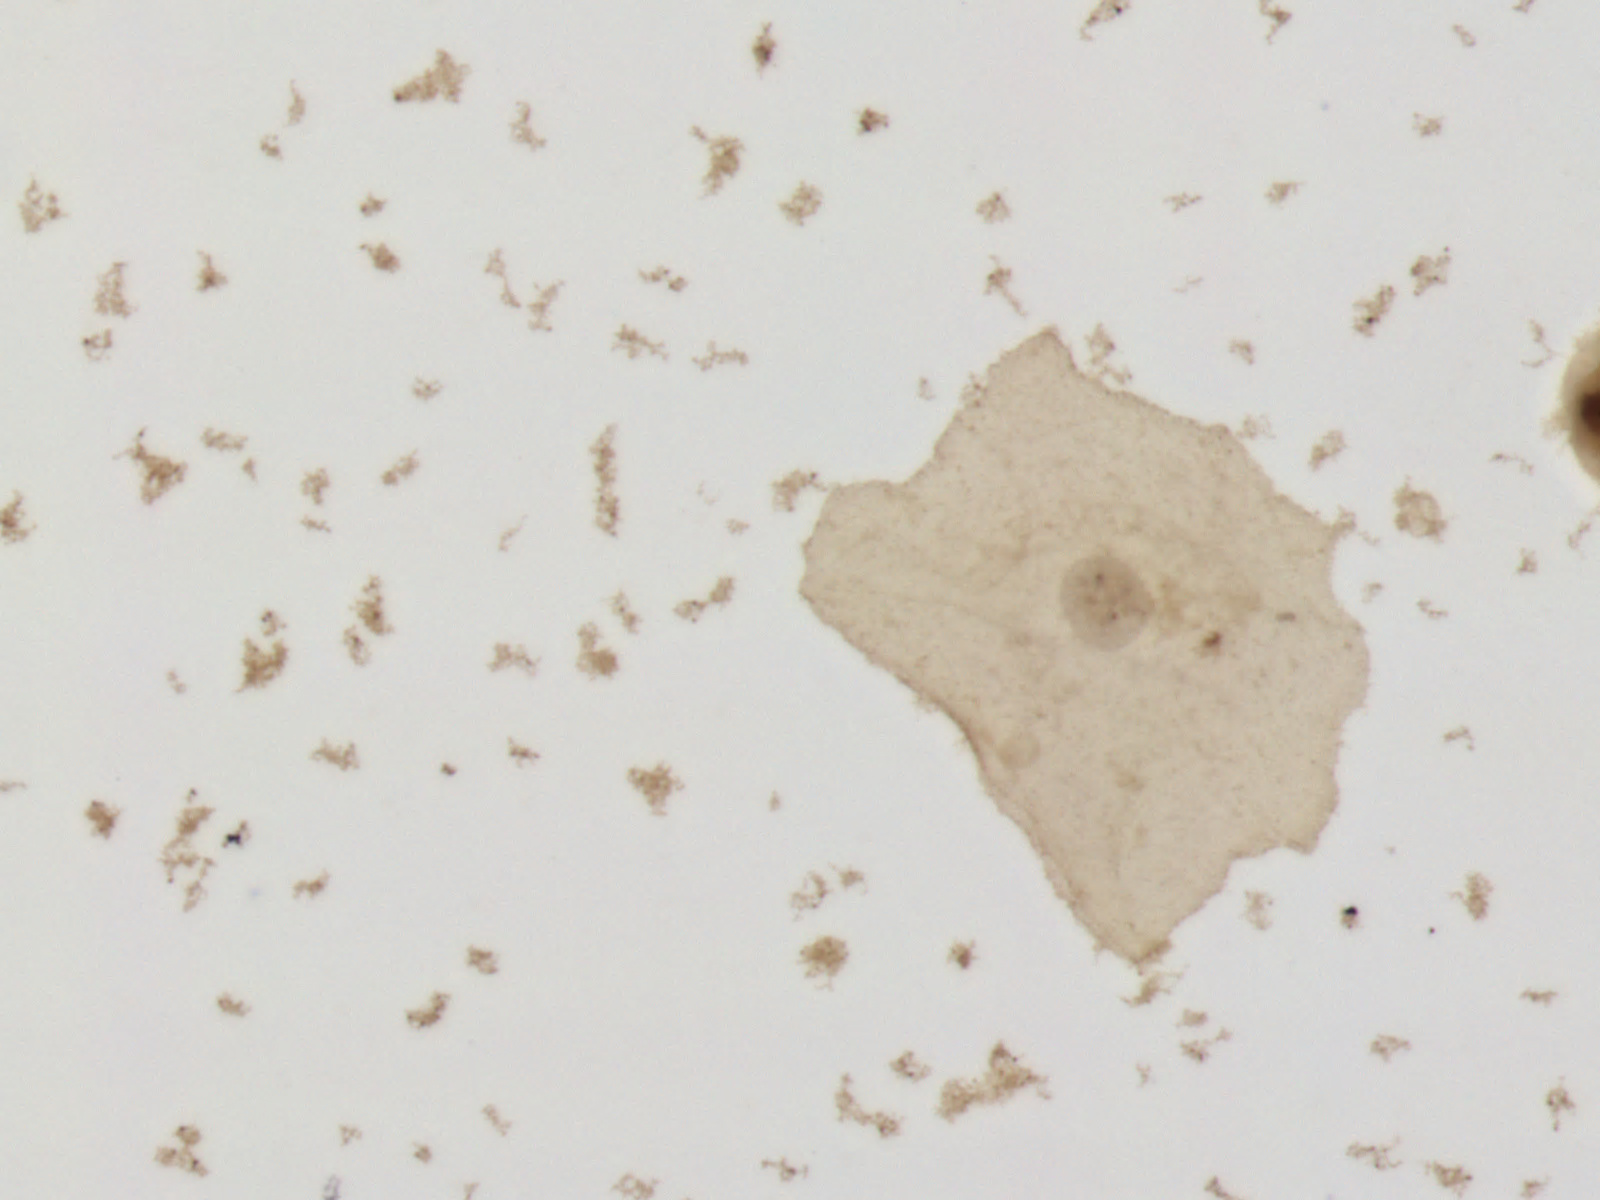

In [ ]:
dataset["train"][0]["image"]

# Augmentations


For this work we use albumentations:

https://albumentations.ai/

```bibtex
@Article{info11020125,
    AUTHOR = {Buslaev, Alexander and Iglovikov, Vladimir I. and Khvedchenya, Eugene and Parinov, Alex and Druzhinin, Mikhail and Kalinin, Alexandr A.},
    TITLE = {Albumentations: Fast and Flexible Image Augmentations},
    JOURNAL = {Information},
    VOLUME = {11},
    YEAR = {2020},
    NUMBER = {2},
    ARTICLE-NUMBER = {125},
    URL = {https://www.mdpi.com/2078-2489/11/2/125},
    ISSN = {2078-2489},
    DOI = {10.3390/info11020125}
}
```

The augmentation functions are applied every time an image is passed from the dataloader to the model during training. So in a single epoch the model trains on one augmented version of each image in the data set.

## Appling a pipeline of augmentations

First, we fix the seeds, and then create a pipeline of transforms from albumentations.

In [ ]:
# Fix seeds for albumentations
import random

import imgaug

random.seed(1609)
imgaug.seed(1609)

albumentations_transforms = [
    A.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5, always_apply=False
    ),
    A.GridDistortion(
        num_steps=5,
        distort_limit=(-0.3, 0.3),
        interpolation=2,
        border_mode=4,
        value=(0, 0, 0),
        mask_value=0,
        p=0.5,
        always_apply=False,
    ),  # testar
    A.ShiftScaleRotate(
        shift_limit=(-0.25, 0.25),
        scale_limit=(-0.5, 0.5),
        rotate_limit=(-90, 90),
        interpolation=2,
        border_mode=3,
        value=(0, 0, 0),
        mask_value=0,
        p=0.5,
        always_apply=False,
    ),
    A.VerticalFlip(p=0.5, always_apply=False),
    A.HorizontalFlip(p=0.5, always_apply=False),
    A.RandomCrop(height=512, width=512, always_apply=True)
    # A.Normalize(
    # mean=(0.67167, 0.7197, 0.77049), std=(0.1557, 0.12242, 0.08686), max_pixel_value=255.0, always_apply=True, p=1.0
    # )
]

alb_transform = A.Compose(albumentations_transforms)

Run the transforms pipeline and plot the image and mask as visualization example

Text(0.5, 1.0, 'transformed Mask')

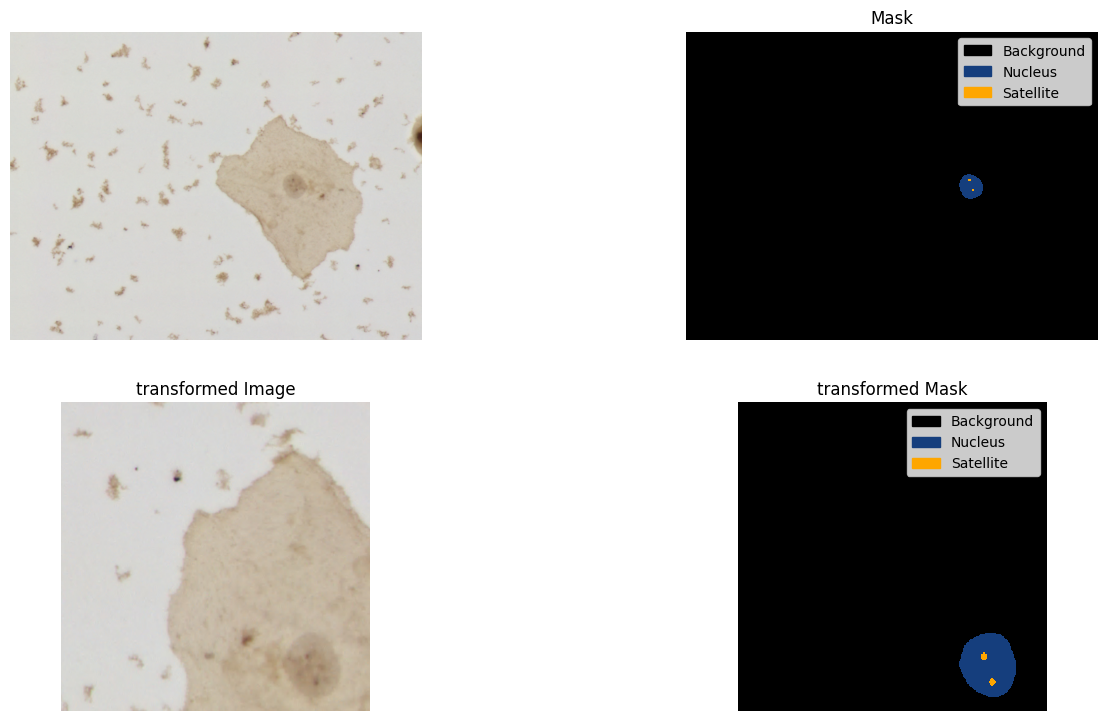

In [ ]:
image = np.array(dataset["train"][0]["image"])
mask = np.array(dataset["train"][0]["annotation"])

transformed = alb_transform(image=image, mask=mask)

transformed_image = transformed["image"]
transformed_mask = transformed["mask"]

fig = plt.figure(figsize=(16, 9), dpi=100)

ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(image)
ax1.set_axis_off()

ax2 = fig.add_subplot(2, 2, 2, sharex=ax1, sharey=ax1)

mask_categories = np.unique(mask)

colors_rgba = {k: tuple([c / 255 for c in v] + [1.0]) for k, v in id2color.items()}
cmap = mlp_colors.ListedColormap([colors_rgba[cat_id] for cat_id in mask_categories])
handles = [
    patches.Patch(color=colors_rgba[cat_id], label=id2label[cat_id])
    for cat_id in mask_categories
]


ax2.imshow(
    mask,
    cmap=cmap,
    vmax=max(mask_categories),
    vmin=min(mask_categories),
    interpolation="nearest",
)
ax2.set_axis_off()
ax2.legend(handles=handles)
ax2.set_title("Mask")


ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(transformed_image)
ax3.set_axis_off()
ax3.set_title("transformed Image")

ax4 = fig.add_subplot(2, 2, 4, sharex=ax3, sharey=ax3)
ax4.imshow(
    transformed_mask,
    cmap=cmap,
    vmax=max(mask_categories),
    vmin=min(mask_categories),
    interpolation="nearest",
)
ax4.set_axis_off()
ax4.legend(handles=handles)
ax4.set_title("transformed Mask")

# Rewrite the model



To use weights at the function loss, we need to rewrite the SegFormer class and foward the weights of the loss function


Copied from https://github.com/huggingface/transformers/blob/6568752039dfba86ba6eb994fd7e29888d5ed4a8/src/transformers/models/segformer/modeling_segformer.py#L741

In [ ]:
from torch.nn import CrossEntropyLoss
from transformers import SegformerDecodeHead, SegformerModel, SegformerPreTrainedModel
from transformers.modeling_outputs import SemanticSegmenterOutput


class SegformerForSemanticSegmentation(SegformerPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.segformer = SegformerModel(config)
        self.decode_head = SegformerDecodeHead(config)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )
        output_hidden_states = (
            output_hidden_states
            if output_hidden_states is not None
            else self.config.output_hidden_states
        )

        outputs = self.segformer(
            pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=True,  # we need the intermediate hidden states
            return_dict=return_dict,
        )

        encoder_hidden_states = outputs.hidden_states if return_dict else outputs[1]

        logits = self.decode_head(encoder_hidden_states)

        loss = None
        if labels is not None:
            if self.config.num_labels == 1:
                raise ValueError("The number of labels should be greater than one")
            else:
                # upsample logits to the images' original size
                upsampled_logits = nn.functional.interpolate(
                    logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
                )

                loss_fct = CrossEntropyLoss(
                    ignore_index=self.config.semantic_loss_ignore_index,
                    weight=torch.Tensor(self.config.loss_function_weights).to(
                        self.device
                    ),
                )
                loss = loss_fct(upsampled_logits, labels)

        if not return_dict:
            if output_hidden_states:
                output = (logits,) + outputs[1:]
            else:
                output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SemanticSegmenterOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states if output_hidden_states else None,
            attentions=outputs.attentions,
        )

# HF definitions

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## CCAgT dataset for Segmentation class

In [ ]:
class CCAgTSeg(Dataset):
    def __init__(self, ccagt_dataset, feature_extractor, transform=None):
        self.ccagt_dataset = ccagt_dataset
        self.transform = transform
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        img = self.ccagt_dataset[idx]["image"].convert("RGB")
        msk = self.ccagt_dataset[idx]["annotation"].convert("L")

        if self.transform is not None:
            transformed = self.transform(image=np.array(img), mask=np.array(msk))
            img = Image.fromarray(transformed["image"])
            msk = Image.fromarray(transformed["mask"])

        encoded_inputs = self.feature_extractor(
            images=img, segmentation_maps=msk, return_tensors="pt"
        )

        for k, v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()  # remove batch dimension

        return encoded_inputs

    def __len__(self):
        return self.ccagt_dataset.num_rows

## Load pretrained SegFormer model

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    num_labels=len(categories_to_train),
    id2label=id2label,
    label2id=label2id,
)

In [ ]:
model.config.loss_function_weights = loss_function_weights
model.config.loss_function_weights

In [ ]:
model.config.semantic_loss_ignore_index

## Metrics code (IoU)

In [ ]:
class IoU(Metric):
    name = "iou_by_cat"
    short_name = "iou"

    def __init__(self, ignore={0}, categories=id2label):  # Ignore background pixels
        self.ignore = ignore
        self.categories = categories
        self._categories_to_compute = {
            k: v for k, v in categories.items() if k not in ignore
        }
        self.reset()

    def reset(self):
        self.intersection = {k: 0.0 for k in self._categories_to_compute}
        self.union = {k: 0.0 for k in self._categories_to_compute}

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        for cat_id in self._categories_to_compute:
            # Get the prediction and target binary mask for `c` category
            p = torch.where(preds == cat_id, 1, 0)
            t = torch.where(target == cat_id, 1, 0)

            intersection_ = (p * t).float().sum().item()
            total_area_ = (p + t).float().sum().item()
            union_ = total_area_ - intersection_

            self.intersection[cat_id] += intersection_
            self.union[cat_id] += union_

    def compute(self):
        def iou(intersection, union):
            return intersection / union if union > 0 else np.nan

        return {
            cat_name: iou(self.intersection[cat_id], self.union[cat_id])
            for cat_id, cat_name in self._categories_to_compute.items()
        }

    @staticmethod
    def to_str(iou_by_cat):
        def fs(word, value):
            size = int((len(word) - 7) / 2)
            ws = " " * size
            txt = f"{ws}{value:.5f}{ws}"
            return txt

        iou_by_cat = dict(iou_by_cat)
        txt_names = "| ".join([k for k in iou_by_cat])
        txt_values = "| ".join([fs(k, v) for k, v in iou_by_cat.items()])
        txt = f"\n\t\t| {txt_names} |"
        txt += f"\n\t\t| {txt_values} |"
        return txt


def compute_mean(
    values,
):
    return np.nanmean(values)


def compute_selected_mean(
    values_by_cat,
    selected_categories=selected_categories,  # Selected categories will be the main categories of CCAgT dataset
    label2id=label2id,
):
    return compute_mean(
        [
            value
            for cat_name, value in values_by_cat.items()
            if label2id[cat_name] in selected_categories
        ]
    )

### Define metrics and monitor best model

In [ ]:
metrics = [IoU]
monitor = "miou_selected_categories"

## Load pretrained SegFormer feature extractor

In [ ]:
feature_extractor = SegformerFeatureExtractor.from_pretrained(
    pretrained_model_name,
    do_resize=False,
    do_normalize=True,  # true needs image_mean and image_std # Issue https://github.com/huggingface/transformers/issues/17714
    image_mean=[0.0, 0.0, 0.0],
    image_std=[1.0, 1.0, 1.0],
)

## Init CCAgT dataset for Segmentation

In [ ]:
dataset_train = CCAgTSeg(
    ccagt_dataset=dataset["train"], feature_extractor=feature_extractor
)

dataset_valid = CCAgTSeg(
    ccagt_dataset=dataset["validation"], feature_extractor=feature_extractor
)

## Move model to GPU

In [ ]:
model.to(device)

model.device

device(type='cuda', index=0)

##  Training code

In [ ]:
def evaluate_step(logits, labels, metrics):
    # evaluate
    with torch.no_grad():
        upsampled_logits = nn.functional.interpolate(
            logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1)

        for m in metrics:
            m.update(predicted, labels)

    return metrics


def training_loop(train_dataloader, metrics, optimizer, device, epoch, scheduler=None):
    train_loss = []
    for idx, batch in enumerate(
        tqdm(train_dataloader, desc="training", unit="steps", leave=False)
    ):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)

        loss, logits = outputs.loss, outputs.logits
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

        metrics = evaluate_step(logits, labels, metrics)
        if scheduler is not None:
            scheduler.step()

    return metrics, np.nanmean(train_loss)


def validation_loop(valid_dataloader, metrics, device):
    valid_loss = []
    for idx, batch in enumerate(
        tqdm(valid_dataloader, desc="validation", unit="steps", leave=False)
    ):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        valid_loss.append(loss.item())

        metrics = evaluate_step(logits, labels, metrics)

    return metrics, np.nanmean(valid_loss)


def compute_and_log(metrics, step, loss, epoch, dt_start, fold):

    extra = {}
    for m in metrics:
        m_output = m.compute()
        m.reset()
        extra[m.name] = m_output
        dt_end = datetime.now()
        done_into = str(dt_end - dt_start)
        tn = dt_end.strftime("%H:%M:%S")
        print("-" * 50)
        print("-" * 22, fold, "-" * 21)
        print("-" * 50)
        print(f"\t{epoch} | {tn} | {fold} | done into: {done_into}")
        print(f"\t{epoch} | {tn} | {fold} | Loss: {loss:.8f}")
        print(f"\t{epoch} | {tn} | {fold} | {m.name}: {m.to_str(m_output)}")

        if m.name.endswith("_by_cat"):
            mean_m = compute_mean(list(m_output.values()))
            mean_selected_m = compute_selected_mean(dict(m_output))

            print(f"\t{epoch} | {tn} | {fold} | m{m.short_name}: {mean_m:.5f}")
            print(
                f"\t{epoch} | {tn} | {fold} | m{m.short_name} selected categories: {mean_selected_m:.5f}"
            )

            extra[f"m{m.short_name}"] = mean_m
            extra[f"m{m.short_name}_selected_categories"] = mean_selected_m

    return metrics, extra


def save_best_model(results, current_best_value, monitor, epoch, dir_path):
    if isinstance(monitor, str):
        if monitor in results:
            v = results[monitor]
        else:
            raise KeyError(
                f"Unexpected value for monitor. Have available: {results.keys()}"
            )
    else:
        v = monitor(results)

    if v >= current_best_value:
        print(
            f"\t{epoch} | Saving best model (last={current_best_value:.5f} | now={v:.5f})..."
        )
        current_best_value = v
        model.save_pretrained(dir_path)

    return current_best_value


def fit(
    *,
    model,
    train_dataloader,
    valid_dataloader,
    epochs,
    optimizer,
    scheduler,
    device,
    metrics,
    monitor,
    path_checkpoints,
    path_best_model,
    epoch_start=0,
):

    _metrics = {"train": [i() for i in metrics], "valid": [i() for i in metrics]}
    metric_bm = 0.0
    model.to(device)
    model.train()
    for epoch in tqdm(
        range(epoch_start, epoch_start + epochs), position=0, unit="epochs"
    ):
        dt_epoch_start = datetime.now()
        step_end = epoch * len(train_dataloader)
        print(f"Epoch: {epoch} -> start at {dt_epoch_start}")

        # Normally the scheduler step is one by epoch, but for Onecycle is for each step
        _metrics["train"], train_loss = training_loop(
            train_dataloader, _metrics["train"], optimizer, device, epoch, scheduler
        )
        _metrics["train"], _ = compute_and_log(
            _metrics["train"], step_end, train_loss, epoch, dt_epoch_start, "train"
        )

        dt_validation_start = datetime.now()
        _metrics["valid"], valid_loss = validation_loop(
            valid_dataloader, _metrics["valid"], device
        )
        _metrics["valid"], results = compute_and_log(
            _metrics["valid"], step_end, valid_loss, epoch, dt_validation_start, "valid"
        )

        # Save checkpoint
        print(f"\t{epoch} | Saving checkpoint...")
        model.save_pretrained(path_checkpoints)

        metric_bm = save_best_model(results, metric_bm, monitor, epoch, path_best_model)

    return model

# Train

## Step1

### Define parameters and load model

In [ ]:
step_name = "step_1"

epochs = 150
batch_size = 8
lr = 1e-4
lr_min = 1e-6
max_lr = 1e-3
weight_decay = 1e-3
num_workers = multiprocessing.cpu_count()

path_checkpoints = os.path.join(drive_output_base_path, step_name)
path_best_model = os.path.join(path_checkpoints, "best_model")

In [ ]:
tfs = A.Compose(albumentations_transforms)

tfs

In [ ]:
# @title Freeze encoder {form-width: "15%", display-mode: "form" }
for param in model.base_model.encoder.patch_embeddings.parameters():
    param.requires_grad = False

In [ ]:
# Set the transforms pipeline
dataset_train.transform = tfs

# Define data loaders
train_dataloader = DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
valid_dataloader = DataLoader(
    dataset_valid, batch_size=batch_size, num_workers=num_workers
)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# Define scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_dataloader),
    epochs=epochs,
    div_factor=max_lr / lr,
    final_div_factor=lr / lr_min,
    verbose=False,
)

### fit model

In [ ]:
!/opt/bin/nvidia-smi
!nvcc --version

In [ ]:
model = fit(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    epochs=epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    metrics=metrics,
    monitor=monitor,
    path_checkpoints=path_checkpoints,
    path_best_model=path_best_model,
    epoch_start=0,
)

## Step2

### Define parameters and load model

In [ ]:
step_name = "step_2"
last_step_name = "step_1"
subdir = "best_model"

epochs = 150
last_epoch_step1 = 150
batch_size = 8
lr = 1e-4
lr_min = 1e-6
max_lr = 1e-3
weight_decay = 1e-3
num_workers = multiprocessing.cpu_count()

path_checkpoints = os.path.join(drive_output_base_path, step_name)
path_best_model = os.path.join(path_checkpoints, "best_model")

In [ ]:
tfs = A.Compose(albumentations_transforms)

tfs

In [ ]:
# @title load best model from last step {form-width: "15%", display-mode: "form" }
model = model.from_pretrained(
    os.path.join(drive_output_base_path, last_step_name, subdir)
).to(device)

In [ ]:
# @title Unfreeze encoder {form-width: "15%", display-mode: "form" }
for param in model.base_model.encoder.patch_embeddings.parameters():
    param.requires_grad = True

In [ ]:
# Set the transforms pipeline
dataset_train.transform = tfs

# Define data loaders
train_dataloader = DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
valid_dataloader = DataLoader(
    dataset_valid, batch_size=batch_size, num_workers=num_workers
)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# Define scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_dataloader),
    epochs=epochs,
    div_factor=max_lr / lr,
    final_div_factor=lr / lr_min,
    verbose=False,
)

### fit model

In [ ]:
!/opt/bin/nvidia-smi
!nvcc --version

In [ ]:
model = fit(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    epochs=epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    metrics=metrics,
    monitor=monitor,
    path_checkpoints=path_checkpoints,
    path_best_model=path_best_model,
    epoch_start=last_epoch_step1 + 1,
)

# Lapixdl evaluation

In [ ]:
cats_names = [n for n, v in sorted(label2id.items(), key=lambda x: x[1])]
cats_names

['Background',
 'Nucleus',
 'Cluster',
 'Satellite',
 'Nucleus_out-of-focus',
 'Overlapped_nuclei',
 'Non-viable_nucleus',
 'Leukocyte_nucleus']

### load model

In [ ]:
step_name = "step_2"

path_checkpoints = os.path.join(drive_output_base_path, step_name)
path_best_model = os.path.join(path_checkpoints, "best_model")

!ls $path_best_model

config.json  pytorch_model.bin


In [ ]:
best_model = model.from_pretrained(path_best_model)
best_model.to(device)

best_model.device

device(type='cuda', index=0)

### Function to evaluate

In [ ]:
def pred_mask_iterator(dataset, model):
    for item in dataset:
        img = item["image"].convert("RGB")

        encoding = feature_extractor(img, return_tensors="pt")
        pixel_values = encoding.pixel_values.to(device)
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits.cpu()

        # First, rescale logits to original image size
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=img.size[::-1],  # (height, width)
            mode="bilinear",
            align_corners=False,
        )

        # Second, apply argmax on the class dimension
        seg = upsampled_logits.argmax(dim=1)[0]

        yield np.array(item["annotation"].convert("L")), seg

In [ ]:
def evaluate(
    dataset,
    fold_name,
    model=model,
    categories=cats_names,
    metrics_choice=["IoU", "F-Score"],
):
    choices_folds = {"valid", "test", "test_slide"}
    if fold_name not in choices_folds:
        raise KeyError("this fold name is not valid")

    print(f"Working into {fold_name} with a total of {dataset.num_rows} items!")

    print(">Get the iterators for GT masks and predicted masks...")
    gt_masks, pred_masks = pred_mask_iterator(dataset, model)

    print(">Evaluating...")
    eval_results = evaluate_segmentation(gt_masks, pred_masks, categories)

    print(">Confusion matrix...")
    fig, ax = eval_results.show_confusion_matrix()
    fig.set_size_inches(16, 9)
    plt.show()

    print(f">Computing metrics ({metrics_choice})...")
    selected_cats = {id2label[c] for c in categories_to_train}

    print(
        f"  >The categories that the model use to train is the same used -> {selected_cats}"
    )
    print("  >Getting the metrics for each category...")
    metrics_by_category = {
        k: v
        for k, v in eval_results.to_dict()["By Class"].items()
        if k in selected_cats
    }

    print("  >Computing the mean of each metric with, and without background...")
    metrics_average = {
        m: np.nanmean([v[m] for v in metrics_by_category.values()])
        for m in metrics_choice
    }
    metrics_average_without_bg = {
        m: np.nanmean(
            [v[m] for k, v in metrics_by_category.items() if k != "Background"]
        )
        for m in metrics_choice
    }

    print(f">Metrics average: {metrics_average_without_bg}")
    print(f">Metrics average with background: {metrics_average}")
    print(">Metrics by category: \n")

    def fmt_metric_value_msg(metrics):
        return "\n\t\t".join(
            [
                f"{metric_name: <15} = {float(metric_value):.4f}"
                if str(metric_value).isdigit()
                else f"{metric_name: <15} = {metric_value}"
                for metric_name, metric_value in metrics.items()
            ]
        )

    msg = "\t" + "\n\t".join(
        [
            f"{cat_name}\n\t\t{fmt_metric_value_msg(v)}"
            for cat_name, v in metrics_by_category.items()
        ]
    )
    print(msg)

    print(">Returning metrics from lapixdl...")
    return eval_results

### Run evaluate

In [ ]:
evaluate(
    dataset["validation"], "valid", best_model, cats_names, ["IoU", "F-Score"]
).to_dataframe()

In [ ]:
evaluate(
    dataset["test"], "test", best_model, cats_names, ["IoU", "F-Score"]
).to_dataframe()